# quickstart 

http://dan.iel.fm/emcee/current/user/quickstart/

Given a probability density of

$$ p(\vec{x}) \propto \exp \left[ -\frac{1}{2} (\vec{x} - \vec{\mu})^T \Sigma^{-1} (\vec{x} - \vec{\mu}) \right]$$

where $\vec{\mu}$ is a N-d vector of the mean of the density and $\Sigma$ is the sqaure NxN covariance matrix

In [55]:
%matplotlib inline
import numpy as np
import emcee
import matplotlib.pyplot as plt

function to evaluate $p(\vec{x}, \vec{\mu}, \Sigma^-1)$. Note that `emcee` requires log probability ($\ln p$) so this simplifies this problem.

$\vec{x}$ is a vector of all of the sampled parameters, a.k.a. a position of a walker. Walkers are instances of chains, but they are not independent.

$\vec{\mu}$ and $\Sigma^-1$ are fixed.

The idea is that the `EnsembleSampler` is similar to the scipy optimize in that the first argument is variable and the others are fixed, e.g. we are calculating likelihoods by 

```python
mu = const
icov = const
likelihood = lambda x: lnp(x, mu, icov)
```
and sampling from likelihood.

In [2]:
def lnp(x, mu, icov):
    diff = x-mu
    return -np.dot(diff, np.dot(icov, diff))/2.0

set up 50 parameters to act as the true values

In [8]:
ndim = 50
means = np.random.rand(ndim)

cov = 0.5 - np.random.rand(ndim**2).reshape((ndim,ndim))
cov = np.triu(cov)
cov += cov.T - np.diag(cov.diagonal())
cov = np.dot(cov, cov)
icov = np.linalg.inv(cov)

initialize some walkers (250!) with random guesses for the parameters

In [9]:
nwalkers = 250
p0 = np.random.rand(ndim*nwalkers).reshape((nwalkers,ndim))

`emcee` uses `EnsembleSampler` objects to do the sampling.

In [12]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnp, args=[means,icov])

Now we'll call the sampler with a 1000 steps and use it as a burn in. We'll pass in our initial guesses as an array of parameters (p0.shape : 250 walkers * 50 parameters). They are automatically initialized as walkers. The prob 

In [61]:
pos, prob, state = sampler.run_mcmc(p0, 100)
sampler.reset()

Finally pass in the burned in walkers

In [62]:
pos, prob, state = sampler.run_mcmc(pos, 1000)

Look at the results:

Check the acceptance ratio as `acceptance_fraction`, where there is one per walker.

`chain` of all the steps from the run (1000) which gives shape (250, 1000, 50) or (nwalkers, steps, parameters) and `flatchain` which flattens all of the walkers and steps in the shape of (nwalkers*steps, parameters).

We'll plot the flatchain result

0.191392
(250, 1000, 50)
(250000, 50)


/Users/brandon/.virtualenvs/espei-emcee/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


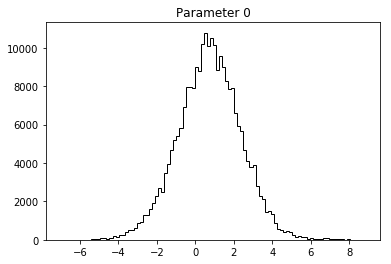

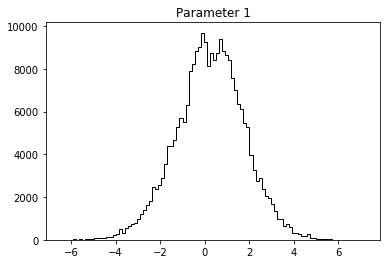

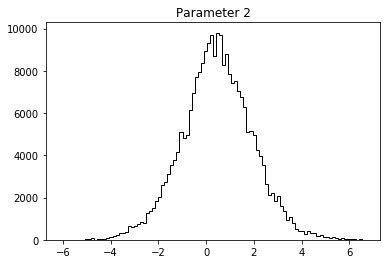

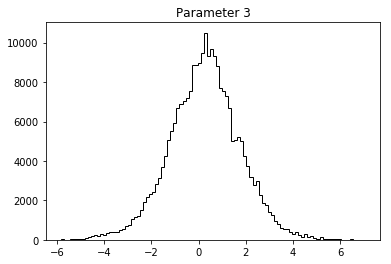

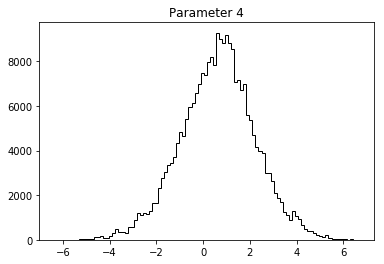

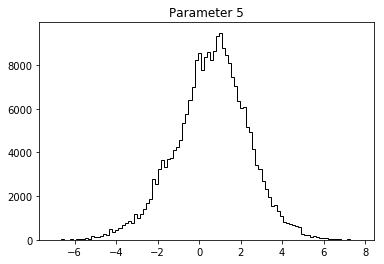

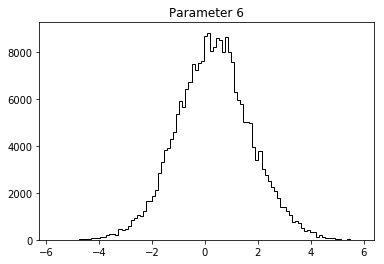

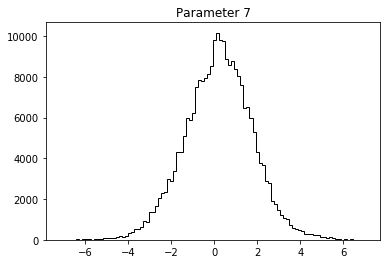

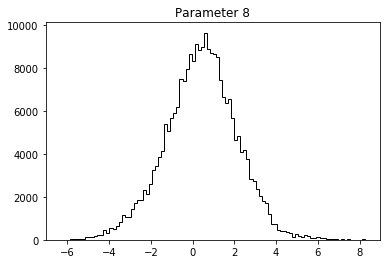

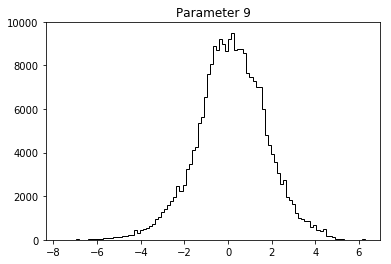

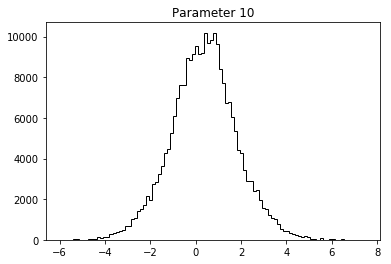

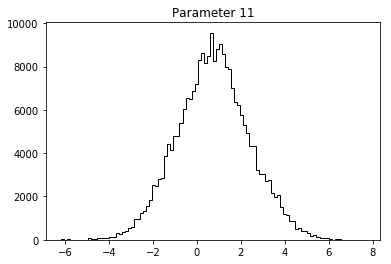

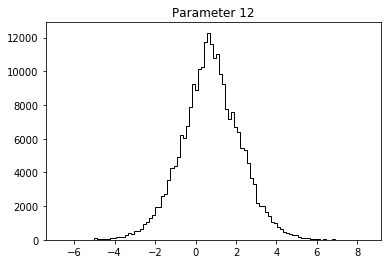

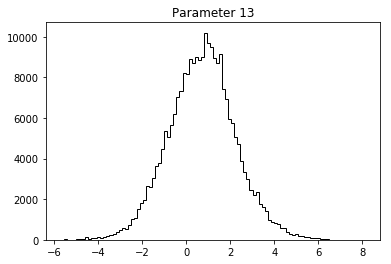

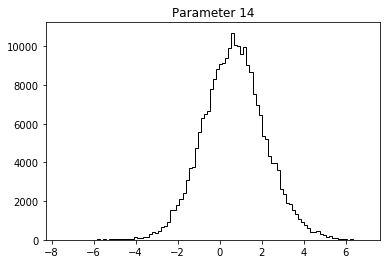

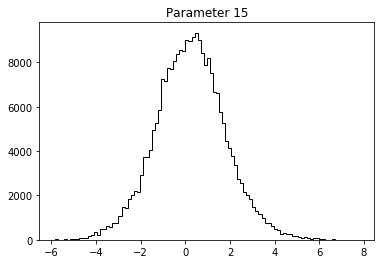

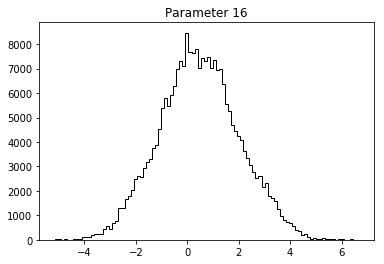

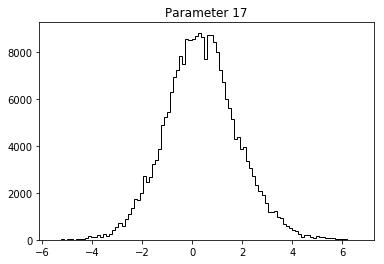

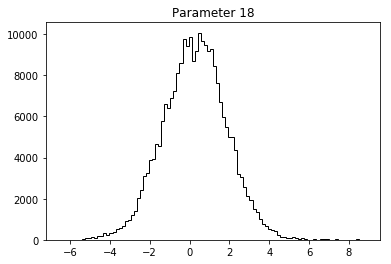

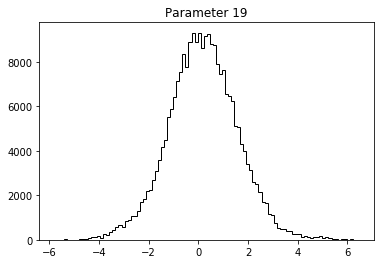

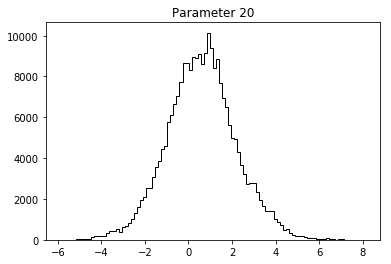

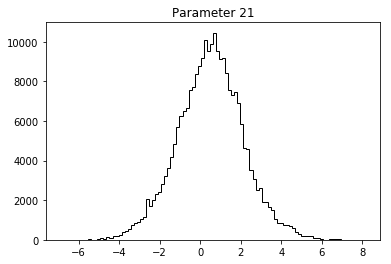

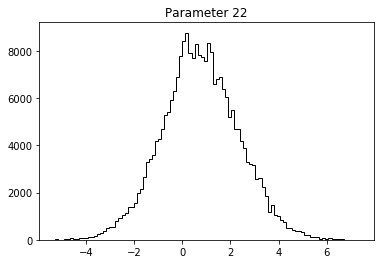

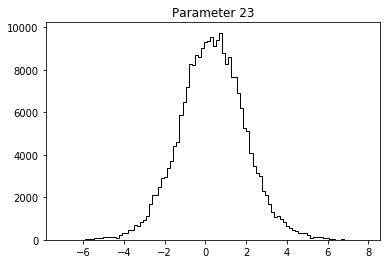

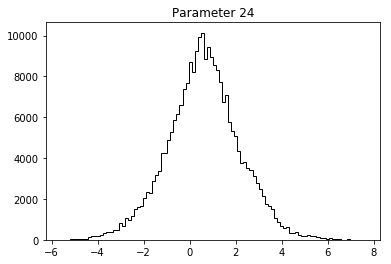

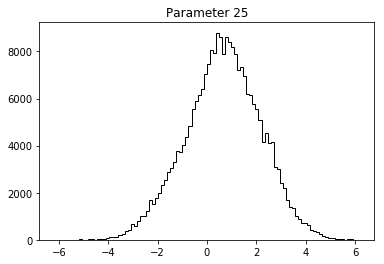

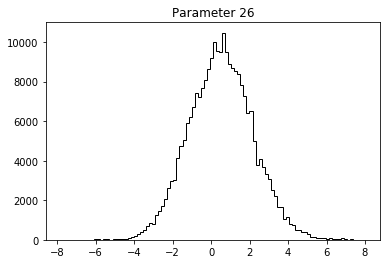

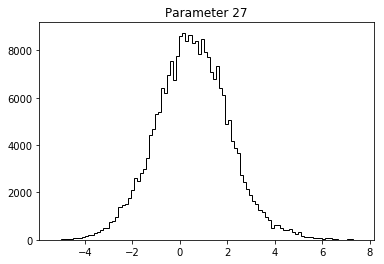

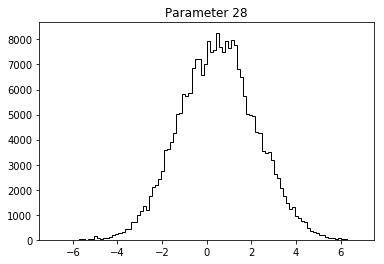

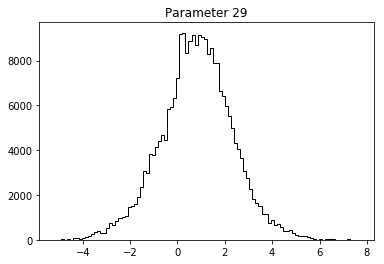

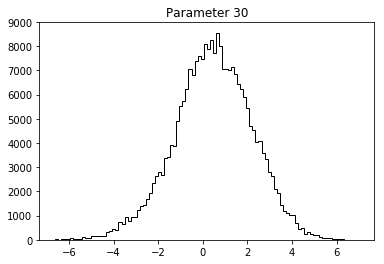

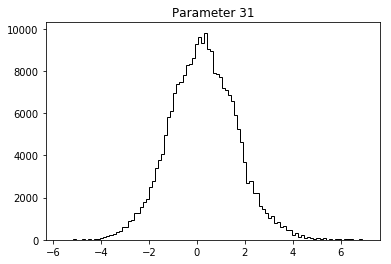

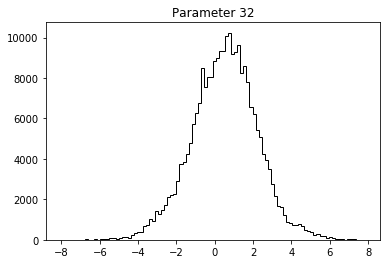

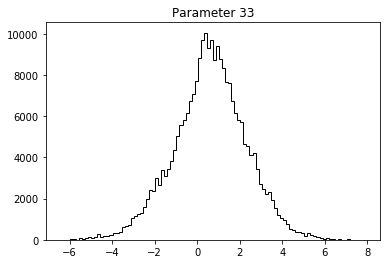

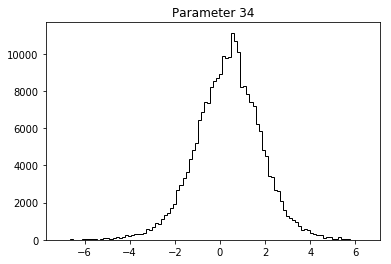

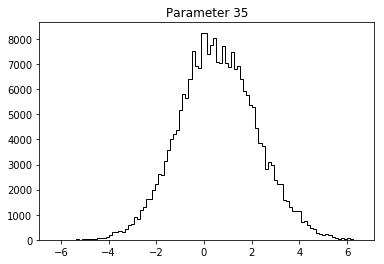

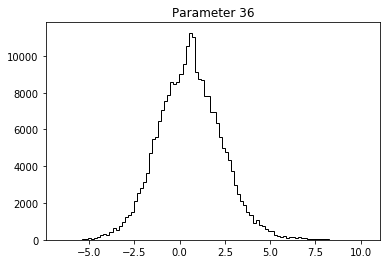

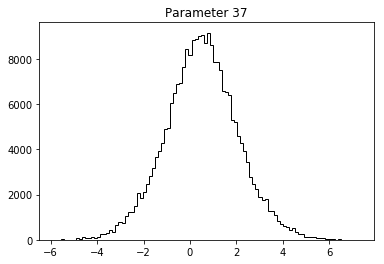

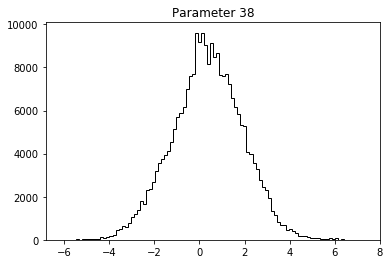

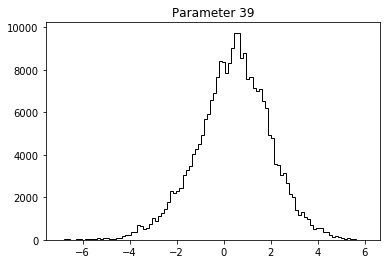

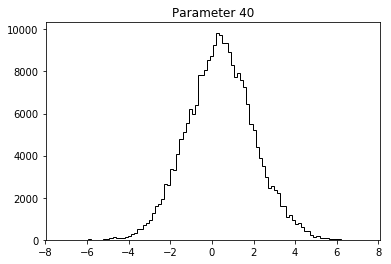

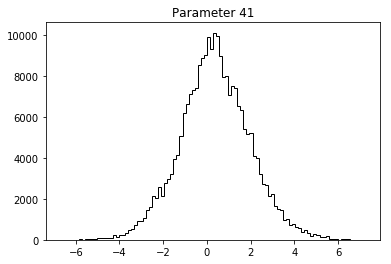

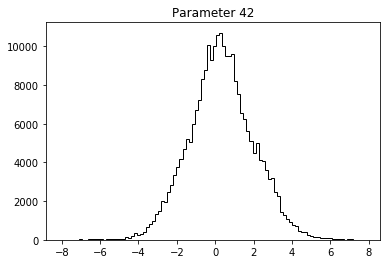

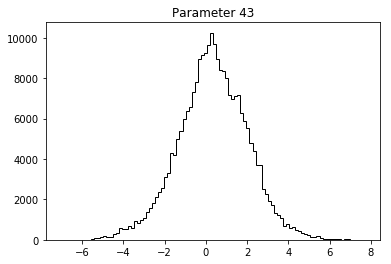

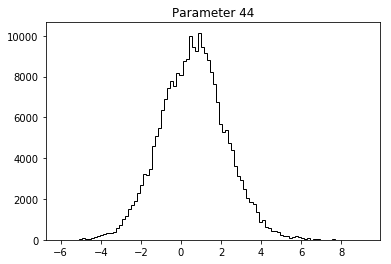

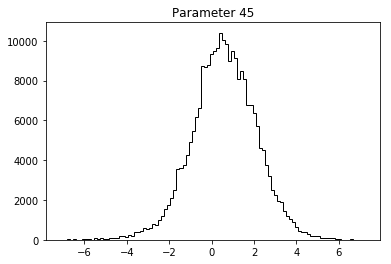

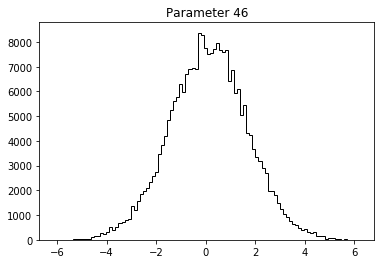

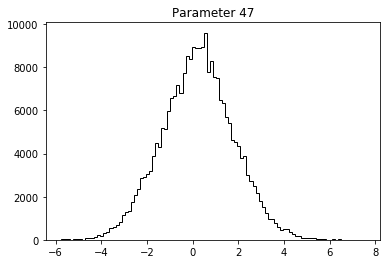

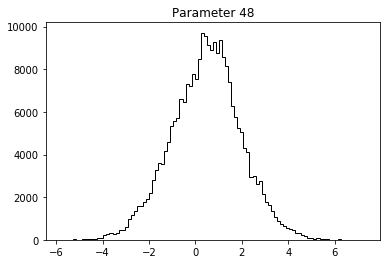

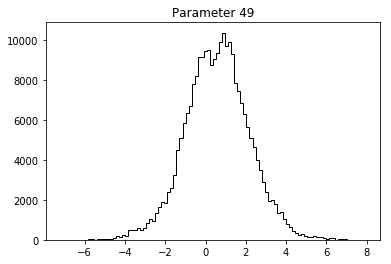

In [63]:
print(np.mean(sampler.acceptance_fraction))
print(sampler.chain.shape)
print(sampler.flatchain.shape)
for i in range(ndim):
    plt.figure()
    plt.hist(sampler.flatchain[:, i], 100, color='k', histtype='step')
    plt.title('Parameter {0:d}'.format(i))

# incrementally saving the chain

In [74]:
# touch the file
fname = 'chain.dat'

f = open(fname, 'w')
f.close()

# note that they recommend opening the file in the loop, but whe should probably do it outside the loop.
# we should also parallelize somehow for our numpy arrays
with open(fname, 'a') as f:
    for result in sampler.sample(p0, iterations=10, storechain=False):
        position = result[0]
        for k in range(position.shape[0]):
            str(k)
            str(position[k])
            f.write("{0:4d} {1:s}\n".format(k, " ".join(map(str,position[k]))))


# progress bar

In [76]:
import sys

nsteps = 5000
width = 30
for i, result in enumerate(sampler.sample(p0, iterations=nsteps)):
    n = int((width+1) * float(i) / nsteps)
    sys.stdout.write("\r[{0}{1}]".format('#' * n, ' ' * (width - n)))
sys.stdout.write("\n")

[##############################]


# multiprocessing
They suggest using the threads option of the EnsembleSampler which uses multiple processers. There's also MPI from emcee.utils. Unclear how to use this with dask or if we need to.

Apparently any pool passed only needs a map method. Client distributed objects have a map